# Raport: przewidywanie braku spłaty kredytu

Zgodnie z założeniem, celem zadania jest wytrenowanie modelu do wdrożenia w produkcji. Przez to rozumiem, że takie kroki jak automatyzacja pozyskiwania i czyszczenia danych (np. przez pobieranie z hurtowni danych i przygotowanie danych w pythonie z pomocą airflow), monitorowanie jakości modelu, CI/CD, konteneryzacja, są poza zakresem tego zadania.

Pierwszymi krokami w celu znalezienia jak najlepszego modelu predykcyjnego, jest zapoznanie się z domeną problemu, dostarczonym zbiorem danych. Odpowiednie przekształcenie tego zbioru oraz eksperymenty z modelami odpowiednimi do zadania.

Poniższy notebook prezentuje eksplorację i przygotowanie zbioru danych, poprzez eksperymenty z różnymi metodami uczenia maszynowego oraz wreszcie porównanie wybranych modeli na odpowiednich metrykach. Gdybym miał więcej czasu, spróbowałbym jeszcze lepiej zrozumieć zbiór danych, co mogłoby przyczynić się do poprawy skuteczności trenowanych modeli. Sprawdziłbym, czy sieci neuronowe (FCNN) mogą być skuteczne. Następnie przygotowałbym skrypty do czyszczenia danych oraz treningu najbardziej obiecujących modeli (xgboost lub catboost), dostrajania hiperparametrów i monitorowania z wykorzystaniem MlFlow.

Podsumowując, aby jak najlpeiej wykorzystać czas na rozwiązanie zadania, skupiłem się na następującyh 3 krokach:

1. Zrozumienie domeny problemu: tutaj posiłkowałem się następującymi kernelami (opis zbioru danych na    https://www.kaggle.com/wordsforthewise/lending-club przekierowuje chyba do przedawnionej strony):  
    https://www.kaggle.com/code/pavlofesenko/minimizing-risks-for-loan-investments/notebook#3.-Modelling-approach  
    https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/notebook#%F0%9F%94%8D-Exploratory-Data-Analysis  
    https://www.kaggle.com/code/mariiagusarova/feature-selection-techniques  

2. Eksploracja i przygotowanie danych:
    - Kodowanie zmiennej objaśnianej. Po usunięciu obserwacji z loan_status=Current zostało 1.3M obserwacji i około 150 zmiennych.
    - Usunięcie duplikatów (akurat nie było żadnych)
    - Analiza wybranej cechy numerczynej i kategorycznej
    - Usunięcie wycieków danych. Na tę część poświęciłem sporo czasu. I dobrze, bo okazało się, że bardzo wiele zmiennych jest niedostępnych w momencie podjęcia decyzji o przyznaniu kradytu. Uwzględnienie ich w zbiorze danych byłoby oszukiwaniem klienta i samego siebie. Część znalazłem samemu, resztę znalazłem w jednym z kerneli.
    - Przekształcenie dat do liczb.
    - Uzupełnienie / usunięcie brakujących wartości. Gdzie się dało, uzupełniłem sensownymi wartościami domyślnymi. Np. wiele zmiennych określało czas od ostatniego zdarzenia (np. bankructwa) i tam zastosowałem uzupełnienie przez maksymalną wartość. Resztę zmiennych usunąłem, jeśli większość wartości była brakująca. W przeciwnym razie uzupełniłem śednią (numeryczne) lub pustym stringiem (kategoryczne).
    - Analiza kowariancji. Usunąłem pary zmiennych, które były ze sobą bardzo mocno skorelowane (Cramer V dla kategorycznych i Pearson dla numerycznych)
    - Usunięcie outlierów.
    - zamieniłem ordynalne na numeryczne i zakodowałem pozostałe kategoryczne z pd.dummify. Ostatecznie miałem około 130 zmiennych.

3. Budowa modeli predykcyjnych: postanowiłem poeksperymentować z następującymi modelami (wszystkie modele miały proporcjonalnie zwiększoną wagę pozytywnej klasy, ze względu na mniejszą jej liczbę w zbiorze danych):
    - Drzewo decyzyjne z pruningiem. Metody drzewiaste generalnie dobrze nadają się do heterogenicznych danych, takich jak te. W dodatku drzewo decyzyjne jest szybkie i może pójść na pierwszy ogień. Można wykorzystać jako baseline.
    - Regresja logistyczna na całych (pozostałych) danych. Skorzystałem SGDClassifier ze scikit-learn, ponieważ jest szybki, co było kluczowe dla zbioru danych z ponad milionem wierszy. Na początek spróbowałem regresji LASSO w celu redukcji liczby zmiennych. LASSO wyzerowało prawie połowę. Następnie zastosowałem GridSearchCV, porównująć regresję logistyczną z liniowym SVM i perceptronem, dla regularyzacji z L1 i L2. Najlepszy wynik osiągnęło linowe SVM z regularyzacją L1 i parametrem alpha=1e-4
    - CatBoost learning_rate=0.03 i 1500 iteracji osiągnął lepsze F1 i roc_auc_score, niż poprzednie modele.
    - xgboost z dostrajaniem hiperparametrów przez hyperopt. Tutaj byłem nieco ograniczony przez zasoby, jednak model wytrenowany z najlepszymi parametrami okazał się pomijalnie (ale jednak) lepszy od CatBoost.
    W tym kroku nie zdecydowałem się na następujące zasugerowane modele:
    - regresja logistyczna z wyborem cech bazującym na rankingu cech z random forest (google: predictor importance): uznałem, że zmienne ważne z perspektywy nieliniowego modelu, jakim jest random forest, niekoniecznie będą najlepsze dla linowego modelu, jakim jest regresja logistyczna;
    - regresja logistyczna z wyborem krokowym cech (google: stepwise feature selection) - wydawało się dość kosztownym krokiem, wolałem poświęcić więcej czasu i mocy obliczeniowej na xgboost.
    - Poniżej zamieszczam porównanie wytrenowanych modeli na wybranych metryk (AUC, precision, recall)


![AUC](auroc.png "AUC")
![Precsion](precision.png "Precision")
![Recall](recall.png "Recall")

In [172]:
import numpy as np
import pickle
import pandas as pd
import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import Pool, CatBoostClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from IPython.display import Image
from itertools import combinations
from scipy.stats import pearsonr, chi2_contingency
from six import StringIO
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    confusion_matrix, precision_recall_curve, roc_auc_score, 
    roc_curve, f1_score, precision_recall_curve
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip')
df.shape

C:\Users\wojtek\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2260701, 151)

In [4]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [6]:
df.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

# Kodowanie zmiennej objaśnianej
Zgodnie z treścią zadania, odrzucam wiersze, gdzie loan_status==Current, koduję Fully Paid jako 0, a resztę jako 1 (czyli wszytkie przypadki, gdzie kredyt nie został w pełni spłacony. Jest to pewne uproszczenie na potrzeby zadania, ponieważ niektóre z tych wartości mogłyby nie być potraktowane jako pozytywy (np. Does not meet the credit policy. Status:Fully Paid)

In [7]:
df = df[df.loan_status != 'Current'].copy()
df.shape

(1382384, 151)

In [8]:
df['target'] = df.loan_status.apply(lambda x: 0 if x == 'Fully Paid' else 1)
df.drop(columns=['loan_status'], inplace=True)
df.target.value_counts()

0    1076751
1     305633
Name: target, dtype: int64

# Deduplikacja

In [9]:
df.drop_duplicates(inplace=True)
df.shape

(1382384, 151)

# Analiza oprocentowania (zmienna numeryczna)

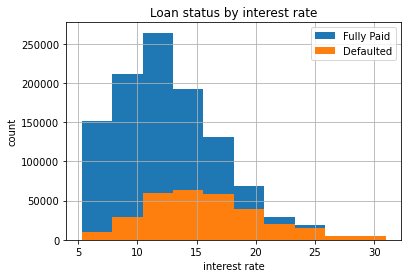

In [10]:
df[df.target==0].int_rate.hist(legend=True)
df[df.target==1].int_rate.hist(legend=True)
plt.xlabel('interest rate')
plt.ylabel('count')
plt.title('Loan status by interest rate')
plt.legend(['Fully Paid', 'Defaulted'])

Wygląda na to, że im wyższe oprocentowanie, tym wieksze ryzyko braku spłaty

# Analiza zmiennej verification status (zmienna kategoryczna)
Zmienna określa, czy kredytobiorcy zostali zweryifkowani pod kontem dodchodu (verified), zweryfkowane jest przynajmniej źródło dochodu (Source Verified), czy nie zostali zweryfikowani.

In [11]:
df.verification_status.value_counts()

Source Verified    536031
Verified           429617
Not Verified       416703
Name: verification_status, dtype: int64

<AxesSubplot:xlabel='verification_status', ylabel='count'>

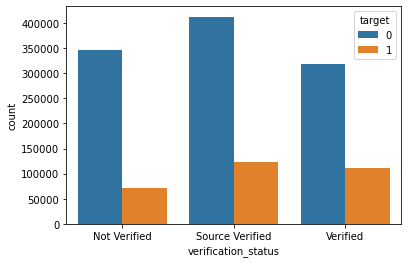

In [12]:
sns.countplot(x='verification_status', data=df, hue='target')

Wygląda na to, że weryfikacja negatywnie koreluje ze spłatą - prawdopodobnie dlatego, że musiały pojawić się pewne podejrzenia skłaniające do weryfikacji.

# Data Leakage
Zbiór danych może zawierać dane niedostępne dla modelu w momencie, kiedy należy podjąć decyzję o przyznaniu kredytu. Zakładam, że w normalnych okolicznościach można uzgodnić z klientem, które ze zmiennych są dostępne w chwili przyznawania kredytu. Szybki research ujawnił jakiś plik excelowy z kolumnami i ich opisami, jednak nie wiem na ile mogę temu ufać. Na szczęście znalazłem [kernel kagglowy](https://www.kaggle.com/code/pavlofesenko/minimizing-risks-for-loan-investments/notebook#4.-Feature-importances), gdzie zmienne niedostępne w momencie podjęcia decyzji są wylistowane na podstawie pliku, które go link niestety wygasł. Jednak sądząc po nazwach tych zmiennych bardzo prawdopodbne, że dane są prawidłowe. Na wszelki wypadek usuwam te zmienne ze zbioru, ponieważ lepiej wyrzucić zbyt wiele zmiennych i niedoszacować skuteczność trenowanych modeli, niż zostawić ich zbyt wiele, ryzykując wyciek danych i zbyt optymistyczne. (No dobra, przyznaję, że wcześniej spróbowałem wytrenować naiwnie jakiś model i uzyskał prawie 100% na danych testowych, więc wróciłem do czyszczenia danych, o było to bardzo podejrzane).

In [13]:
leak_vars = ['collection_recovery_fee', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'funded_amnt_inv',
       'hardship_amount', 'hardship_dpd', 'hardship_end_date',
       'hardship_flag', 'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'issue_d', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
       'last_pymnt_d', 'mo_sin_old_il_acct',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'next_pymnt_d', 'orig_projected_additional_accrued_interest',
       'out_prncp', 'out_prncp_inv', 'payment_plan_start_date',
       'policy_code', 'pymnt_plan', 'recoveries', 'settlement_amount',
       'settlement_date', 'settlement_percentage', 'settlement_status',
       'settlement_term', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp',
       'verification_status', 'verification_status_joint']

correct = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

leak_vars = [x for x in leak_vars if x not in correct]
leak_vars

['collection_recovery_fee',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'funded_amnt_inv',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'issue_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'last_pymnt_d',
 'next_pymnt_d',
 'orig_projected_additional_accrued_interest',
 'out_prncp',
 'out_prncp_inv',
 'payment_plan_start_date',
 'policy_code',
 'pymnt_plan',
 'recoveries',
 'settlement_amount',
 'settlement_date',
 'settlement_percentage',
 'settlement_status',
 'settlement_term',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp']

In [14]:
df.drop(columns=leak_vars, inplace=True)
df.shape

(1382384, 110)

# Zmienne kategoryczne - sprawdzenie typów
w tej części skupiam się na zmiennych kategorycznych, domyślnie kodowanych jako str. Sprawdzam, czy można je zakodować w bardziej przydatny i wygodny sposób dla tego problemu

In [15]:
categorical = df.loc[:, df.dtypes==object].columns
numerical = [x for x in df.columns if x not in categorical]

In [16]:
df[categorical].head()

,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type,verification_status_joint,sec_app_earliest_cr_line,disbursement_method
0,68407277,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,Aug-2003,w,Individual,NaN,NaN,Cash
1,68355089,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,Dec-1999,w,Individual,NaN,NaN,Cash
2,68341763,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,Aug-2000,w,Joint App,Not Verified,NaN,Cash
4,68476807,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,Jun-1998,w,Individual,NaN,NaN,Cash
5,68426831,36 months,C,C3,Veterinary Tecnician,4 years,RENT,Source Verified,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,300xx,GA,Oct-1987,w,Individual,NaN,NaN,Cash


In [17]:
df.sec_app_earliest_cr_line.describe()

count        22092
unique         585
top       Aug-2006
freq           227
Name: sec_app_earliest_cr_line, dtype: object

In [18]:
date_cols = ['earliest_cr_line', 'sec_app_earliest_cr_line']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)

df[date_cols].head()

,earliest_cr_line,sec_app_earliest_cr_line
0,2003-08-01,NaT
1,1999-12-01,NaT
2,2000-08-01,NaT
4,1998-06-01,NaT
5,1987-10-01,NaT


# Zmienne z brakującymi wartościami
Z jednej strony aż kusi, żeby pozbyć się zmiennych, gdzie brakuje ponad 50% wartości. Z drugiej strony, po spojrzeniu na kolumny, gdzie brakuje dużo danych widać, że często może to przemawiać na korzyść kredytobiorcy (np. brak wartości dla zmiennych hardship_* sugeruje, że kredytobiorca nie potrzebował pomocy czy ulgi w spłacie kredytu.
W normalncyh warunkach pewnie warto by było zgłębić temat i wypełnić brakujące dane w sensowny sposób. Tutaj pobieżnie sprawdzę zmienne z barkującymi wartościami i postaram się uzupełnić je w sensowny sposób. Pozostałe kolunmy uzupełnię w jakiś domyślny sposób (średnia zmiennej, pusty string itd...) jeśli brakuje mniej niż 50% wartości, pozostałe usuwam.

In [19]:
miss_props = []
for column in df.columns:
    miss_count = df[column].isna().sum()
    if miss_count != 0:
        miss_props.append((column, miss_count / df.shape[0]))

miss_props.sort(key=lambda x: x[1], reverse=True)

In [20]:
len(miss_props)

108

In [21]:
miss_props

[('member_id', 1.0),
 ('sec_app_mths_since_last_major_derog', 0.9941383870183683),
 ('sec_app_revol_util', 0.9843046505167884),
 ('revol_bal_joint', 0.984019635643931),
 ('sec_app_fico_range_low', 0.9840189122559289),
 ('sec_app_fico_range_high', 0.9840189122559289),
 ('sec_app_earliest_cr_line', 0.9840189122559289),
 ('sec_app_inq_last_6mths', 0.9840189122559289),
 ('sec_app_mort_acc', 0.9840189122559289),
 ('sec_app_open_acc', 0.9840189122559289),
 ('sec_app_open_act_il', 0.9840189122559289),
 ('sec_app_num_rev_accts', 0.9840189122559289),
 ('sec_app_chargeoff_within_12_mths', 0.9840189122559289),
 ('sec_app_collections_12_mths_ex_med', 0.9840189122559289),
 ('verification_status_joint', 0.9787844766721837),
 ('dti_joint', 0.9786014595076332),
 ('annual_inc_joint', 0.9785992893436266),
 ('desc', 0.9088704730378824),
 ('mths_since_last_record', 0.8295560423153046),
 ('mths_since_recent_bc_dlq', 0.7628495410826515),
 ('mths_since_last_major_derog', 0.736560174307573),
 ('mths_since_rec

desc to najwyrazniej opis kredytobiorcy - analiza tekstu wykracza poza zakres tego zadania w tych ramach czasowych

In [22]:
df.desc.unique()

array([nan,
       'We knew that using our credit cards to finance an adoption would squeeze us, but then medical and other unexpected expenses made the situation almost impossible. We are a stable family in a stable community. We just need to break a cycle of debt that is getting worse.',
       "I had a bad year two years ago, with some late and missed payments. I'm doing much better now, but I've got fees and some higher interest bits that have added up on top of the other stuff, and it's a little crazy. I'm hoping doing it thru Lending Club will make it easier - and cheaper - to pay off.",
       ...,
       '  Borrower added on 12/06/11 > Want to close down credit cards and pay them off.  This way I will only have one payment a month for the loan,, will make it alot easier for monthly money magagement<br>',
       "I currently have a loan out with CashCall. The interest rate is 96%! At the time I took out the loan, it helped with a family crisis, but now the interest is crazy to b

In [23]:
# dpd stands for days past due
# remove all sec_app into binary
fill_max = ['mths_since_last_record', 'mths_since_recent_bc_dlq', 
            'mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 
            'mths_since_rcnt_il', 'mths_since_last_delinq', 'mths_since_recent_bc',
            'mths_since_recent_inq', 'mths_since_last_delinq']
fill_empty = ['emp_title', 'verification_status_joint']
fill_avg = ['annual_inc_joint']

In [24]:
df[fill_empty] = df[fill_empty].fillna('')
df[fill_avg] = df[fill_avg].fillna(df[fill_avg].mean())
# to cos nie dziala 
# df[fill_max] = df[fill_max].fillna(df[fill_max].max())
for col in fill_max:
    df[col] = df[col].fillna(df[col].max())

A pozostale zmienne ususwam jesli brakuje wiekszosci, a dla reszty: pusty string dla zmiennych kategorycznych i srednia dla numerycznych. I zamieniam sec_app* w binarna na podstawie sec_app_fico_range_low - 1 jesli notnull, a reszta 0

In [25]:
df['sec_app'] = 0
df.at[df.sec_app_fico_range_low.notnull(), 'sec_app'] = 1
df.sec_app.value_counts()

0    1360292
1      22092
Name: sec_app, dtype: int64

In [26]:
sec_app_cols = [x for x in df.columns if 'sec_app_' in x]
df.drop(columns=sec_app_cols, inplace=True)

In [27]:
miss_props = [x for x in miss_props if x[0] not in fill_max + fill_avg + fill_empty + sec_app_cols]
len(miss_props)

85

In [28]:
cols_to_drop = [x[0] for x in miss_props if x[1] > 0.5]
len(cols_to_drop)

17

In [29]:
cols_to_fill = [x[0] for x in miss_props if x[0] not in cols_to_drop]
len(cols_to_fill)

68

In [30]:
df.drop(columns=cols_to_drop, inplace=True)

In [31]:
df.shape

(1382384, 82)

In [32]:
numerical_to_fill = list(set(cols_to_fill).intersection(set(numerical)))
len(numerical_to_fill)

53

In [33]:
categorical_to_fill = [x for x in cols_to_fill if x not in numerical_to_fill and x not in date_cols]
len(categorical_to_fill)

14

In [34]:
df[numerical_to_fill] = df[numerical_to_fill].fillna(df[numerical_to_fill].mean())

In [35]:
df[categorical_to_fill] = df[categorical_to_fill].fillna('')

# Pozostałych brakujących jest tak mało, że można je usunąć

In [36]:
for column in df.columns:
    miss_count = df[column].isna().sum()
    if miss_count != 0:
        print((column, miss_count / df.shape[0]))

('earliest_cr_line', 4.485005613490897e-05)


In [37]:
df.dropna(inplace=True)

In [38]:
categorical = df.loc[:, df.dtypes==object].columns
numerical = [x for x in df.columns if x not in categorical]

Na koniec sprawdzam, czy jakieś zmienne mają tylko jedną wartość, lub mają ich bardzo wiele (kategoryczne). Jeśli zmienna kategoryczna ma ponad 10000 wartości, to raczej nie starczy pamięci na jej zakodowanie

In [39]:
for col in categorical:
    if df[col].nunique() > 10000 or df[col].nunique() == 1:
        print(col, df[col].nunique())
for col in numerical:
    if df[col].nunique() == df.shape[0] or df[col].nunique() == 1:
        print(col, df[col].nunique())

id 1382322
emp_title 385442
url 1382322
title 63141


Wygląda na to, że powyższe zmienne też można wyrzucić, bo są bezużyteczne dla modelu lub zbyt kosztowne do zakodowania

In [40]:
df.drop(columns=['id', 'url', 'emp_title', 'title'], inplace=True)

# Analiza kowariancji

In [41]:
categorical = df.loc[:, df.dtypes==object].columns
numerical = [x for x in df.columns if x not in categorical]

In [42]:
comb_categorical = list(combinations(categorical, 2))
corrs = []
for comb in comb_categorical:
    table = pd.pivot_table(df, values='target', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corrs.append((comb, corr))

In [43]:
high_corrs = [x for x in corrs if x[1] > 0.95]
high_corrs

[(('grade', 'sub_grade'), 1.0),
 (('zip_code', 'addr_state'), 0.9933900545438705),
 (('application_type', 'verification_status_joint'), 0.9955697369696175)]

Powyższe pary są tak skorelowane, że można usunąć po jednej z każdej pary. Usunę te o większej kardynalności, żeby przyspieszyć trening modeli i ograniczyć rozmiar danych

In [44]:
df.drop(columns=['sub_grade', 'zip_code', 'verification_status_joint'], inplace=True)
df.shape

(1382322, 75)

Teraz czas na analizę zmiennych numerycznych - zacznę od przkeształcenia dat do floatów (liczba dni od 1970-01-01)
Następnie zmierzę korelację Pearsona

In [45]:
df[df.select_dtypes(include=['datetime64']).columns] = (df.select_dtypes(include=['datetime64']) - np.datetime64('1970-01-01')) / np.timedelta64(1, 'D')

In [46]:
comb_numerical = list(combinations(numerical, 2))
corrs = []
for comb in comb_numerical:
    corr = pearsonr(df[comb[0]], df[comb[1]])[0]
    if corr > 0.95:
        corrs.append((comb, corr))

In [47]:
corrs

[(('loan_amnt', 'funded_amnt'), 0.9995602195931913),
 (('loan_amnt', 'installment'), 0.9528731489044149),
 (('funded_amnt', 'installment'), 0.9535202063968274),
 (('fico_range_low', 'fico_range_high'), 0.9999999318624195),
 (('open_acc', 'num_sats'), 0.9815538522497222),
 (('tot_cur_bal', 'tot_hi_cred_lim'), 0.9730879721057095),
 (('num_actv_rev_tl', 'num_rev_tl_bal_gt_0'), 0.9819769795218982)]

Usuwam po jednej zmiennej z każdej powyższej pary. Utworzę zmienną fico będącą średnią fico_range_high i low i usunę obydwie kolumny

In [48]:
df['fico'] = (df.fico_range_high + df.fico_range_low) / 2

In [49]:
df.drop(columns=set([x[0][1] for x in corrs]+['fico_range_low']), inplace=True)
df.shape

(1382322, 69)

# Usuwanie Outlierów
Usunę skrajne wartości dla annual_inc, revol_bal, bc_open_to_buy

In [50]:
df = df[df.annual_inc < df['annual_inc'].quantile(0.99)]
df = df[df.bc_open_to_buy < df['bc_open_to_buy'].quantile(0.999)]
df = df[df.revol_bal < df['revol_bal'].quantile(0.999)]
df.shape

(1365761, 69)

In [51]:
categorical = df.loc[:, df.dtypes==object].columns
numerical = [x for x in df.columns if x not in categorical]

# Zmienne ordynalne
Grade to zmienna ordynalna, bo określa przewidywane ryzyko braku spłaty w skali od A do F
Emp_length okresla długość zatrudnienia, więc też można ją zakodować numerycznie

In [52]:
df[categorical].nunique()

term                    2
grade                   7
emp_length             12
home_ownership          6
verification_status     3
purpose                14
addr_state             51
initial_list_status     2
application_type        2
disbursement_method     2
dtype: int64

In [53]:
df.emp_length.unique(), df.grade.unique()

(array(['10+ years', '3 years', '4 years', '6 years', '7 years', '8 years',
        '2 years', '5 years', '9 years', '< 1 year', '1 year', ''],
       dtype=object),
 array(['C', 'B', 'F', 'A', 'E', 'D', 'G'], dtype=object))

In [54]:
repl_dict = {
    'emp_length': {
        '< 1 year': 0, 
        '1 year': 1, 
        '2 years': 2, 
        '3 years': 3, 
        '4 years': 4, 
        '5 years': 5, 
        '6 years': 6, 
        '7 years': 7, 
        '8 years': 8, 
        '9 years': 9,                               
        '10+ years': 10,
        '': 5
    },
    'grade': {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
        'G': 6
    }
}

df.replace(repl_dict, inplace=True)

In [55]:
df.emp_length = df.emp_length.apply(int)
df.grade = df.grade.apply(int)

# Dzielę dane na zbiór treningowy, walidacyjny i testowy

In [56]:
categorical = df.loc[:, df.dtypes==object].columns
numerical = [x for x in df.columns if x not in categorical]

In [57]:
df = pd.get_dummies(df, columns=categorical, drop_first=True)

In [58]:
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df.target, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1, stratify=df_train.target, random_state=42)

In [59]:
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)
df_val.to_csv('val.csv', index=False)

In [3]:
df_train = pd.read_csv('train.csv', keep_default_na=False)
df_test = pd.read_csv('test.csv', keep_default_na=False)
df_val = pd.read_csv('val.csv', keep_default_na=False)

In [4]:
def df_train_prep(train, val, test):
    y_train = train.target
    X_train = train.drop(columns=['target'])
    y_val = val.target
    X_val = val.drop(columns=['target'])
    y_test = test.target
    X_test = test.drop(columns=['target'])
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = df_train_prep(df_train, df_val, df_test)

# Drzewo decyzyjne z pruningiem i wizualizacją

In [10]:
def report_metrics(y, pred):
    acc_test = accuracy_score(y, pred)
    prec_test = precision_score(y, pred)
    rec_test = recall_score(y, pred)
    f1_test = f1_score(y, pred)
    roc_test = roc_auc_score(y, pred)
    print(
        f'''Accuracy (test): {acc_test:.3f}
        Precision (test): {prec_test:.3f}
        Recall (test): {rec_test:.3f}
        f1 (test): {f1_test:.3f}
        roc-auc (test): {roc_test:.3f}''')

In [46]:
dtree = DecisionTreeClassifier(class_weight='balanced')
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [47]:
report_metrics(y_test, y_pred)

Accuracy (test): 0.694
        Precision (test): 0.314
        Recall (test): 0.320
        f1 (test): 0.317
        roc-auc (test): 0.560


In [48]:
y_pred = dtree.predict(X_train)
report_metrics(y_train, y_pred)

Accuracy (test): 1.000
        Precision (test): 1.000
        Recall (test): 1.000
        f1 (test): 1.000
        roc-auc (test): 1.000


In [49]:
dtree.tree_.max_depth

69

Drzewo decyzyjne na domyslnych parametrach mocno dopasowuje się do danych testowych. Maksymalna głębokość to 69. Widać, że drzewo potrzebuje mocnego ograniczenia głębokości. Wytrenuję drzewa o głębokości od 1 do 20 i porównam ich roc_auc_score na treningowym i walidacyjym.

In [50]:
roc_train = []
roc_val = []
for i in range(1, 21):
    dtree = DecisionTreeClassifier(class_weight='balanced', max_depth=i)
    dtree.fit(X_train, y_train)
    y_pred_train = dtree.predict(X_train)
    y_pred_val = dtree.predict(X_val)
    roc_train.append(roc_auc_score(y_train, y_pred_train))
    roc_val.append(roc_auc_score(y_val, y_pred_val))

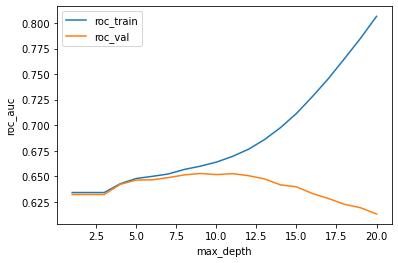

In [51]:
plt.plot(range(1, 21), roc_train, label='roc_train')
plt.plot(range(1, 21), roc_val, label='roc_val')
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.legend()

Wygląda na to, że najlepszy wynik został osiągnięty dla max_depth=9

In [55]:
dtree = DecisionTreeClassifier(class_weight='balanced', max_depth=9)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=9)

In [56]:
with open('dtree.pkl', 'wb') as f:
    pickle.dump(dtree, f)

In [57]:
y_pred = dtree.predict(X_test)
report_metrics(y_test, y_pred)

Accuracy (test): 0.643
        Precision (test): 0.346
        Recall (test): 0.686
        f1 (test): 0.460
        roc-auc (test): 0.658


In [58]:
y_pred = dtree.predict(X_train)
report_metrics(y_train, y_pred)

Accuracy (test): 0.643
        Precision (test): 0.347
        Recall (test): 0.691
        f1 (test): 0.462
        roc-auc (test): 0.660


# Regresja Logistyczna
Przeskaluję dane, ponieważ czytałem, że to może przyspieszyć zbieżność funkcji kosztu. Wykorzystam SGDClassifier, ponieważ jest szbszy, niż LogisticRegression. W dodatku można łatwo porównać z liniowym SVM i perceptronem, wykorzystując GridSearchCV

In [ ]:
sgd = SGDClassifier(max_iter=1000)
    
params = {
    'loss': ['hinge', 'log', 'perceptron'],
    'penalty': ['l1', 'l2'],
    'alpha': [1e-3, 1e-4, 1e-5]
}

clf = GridSearchCV(sgd, params)

In [6]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [37]:
lreg = SGDClassifier(loss='log', class_weight='balanced', penalty='l1')
lreg.fit(X_train_scaled, y_train)
y_pred = lreg.predict(X_test_scaled)

In [38]:
report_metrics(y_test, y_pred)

Accuracy (test): 0.685
        Precision (test): 0.373
        Recall (test): 0.618
        f1 (test): 0.465
        roc-auc (test): 0.661


In [39]:
y_pred = lreg.predict(X_train_scaled)
report_metrics(y_train, y_pred)

Accuracy (test): 0.683
        Precision (test): 0.371
        Recall (test): 0.617
        f1 (test): 0.463
        roc-auc (test): 0.659


In [40]:
np.count_nonzero(lreg.coef_.ravel()) / lreg.coef_.ravel().shape[0]

0.5447761194029851

Czyli regresja logistyczna LASSO ogranicza wymiarowość o prawie połowę.

In [31]:
X_scaled = np.append(X_train_scaled, X_val_scaled, axis=0)
y = np.append(y_train, y_val)

In [41]:
sgd = SGDClassifier(max_iter=1000, class_weight='balanced')
    
params = {
    'loss': ['hinge', 'log', 'perceptron'],
    'penalty': ['l1', 'l2'],
    'alpha': [1e-3, 1e-4, 1e-5]
}

cv = GridSearchCV(sgd, params, cv=3, scoring='roc_auc')
cv.fit(X_scaled, y)

GridSearchCV(cv=3, estimator=SGDClassifier(class_weight='balanced'),
             param_grid={'alpha': [0.001, 0.0001, 1e-05],
                         'loss': ['hinge', 'log', 'perceptron'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [42]:
cv.best_score_, cv.best_params_

(0.7203675999217842, {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'})

In [43]:
y_pred = cv.predict(X_test_scaled)
report_metrics(y_test, y_pred)

Accuracy (test): 0.649
        Precision (test): 0.351
        Recall (test): 0.688
        f1 (test): 0.465
        roc-auc (test): 0.663


In [44]:
y_pred = cv.predict(X_train_scaled)
report_metrics(y_train, y_pred)

Accuracy (test): 0.647
        Precision (test): 0.350
        Recall (test): 0.687
        f1 (test): 0.464
        roc-auc (test): 0.662


# CatBoost

In [60]:
pool_train = Pool(X_train, y_train)
pool_val = Pool(X_val, y_val)
pool_test = Pool(X_test, y_test)

n = y_train.value_counts()
catboost = CatBoostClassifier(learning_rate=0.03,
                           iterations=1500,
                           early_stopping_rounds=100,
                           class_weights=[1, n[0] / n[1]],
                           verbose=False,
                           random_state=0)
catboost.fit(pool_train, eval_set=pool_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
y_pred_test = catboost.predict(pool_test)

report_metrics(y_test, y_pred_test)

Accuracy (test): 0.670
        Precision (test): 0.369
        Recall (test): 0.689
        f1 (test): 0.481
        roc-auc (test): 0.677


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

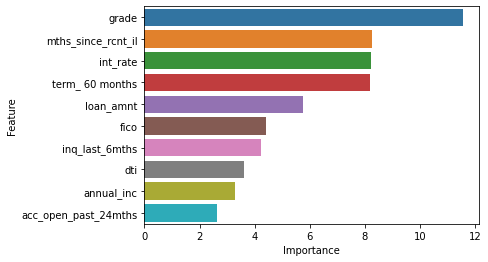

In [62]:
df = pd.DataFrame({'Feature': catboost.feature_names_, 'Importance': catboost.feature_importances_})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df)

In [63]:
confusion_matrix(y_test, y_pred_test)

array([[70596, 35683],
       [ 9425, 20873]], dtype=int64)

In [65]:
catboost.save_model('catboost.cbm')

# Xgboost z dostrajaniem hyperopt
Na koniec próbuję wytrenować xgboost z dostrajaniem hiperparametrów za pomocą hyperopt (optymalizacja Bayesowska).
Ze względu na rozmiar danych i ograniczone zasoby, zapuszcza, tylko na 50 iteracji.

In [159]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 20)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1)
}
n = y_train.value_counts()

In [156]:
def objective(space):
    clf = xgb.XGBClassifier(scale_pos_weight=(n[0] / n[1]), n_estimators=100, **space)
    
    evaluation = [( X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=5,verbose=False)
    

    pred = clf.predict(X_val)
    auc = roc_auc_score(y_val, pred>0.5)
    print ("SCORE:", auc)
    return {'loss': -auc, 'status': STATUS_OK }

In [157]:
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
)

best_params

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6708797371180026                                                                                                     
  2%|▉                                               | 1/50 [00:55<45:08, 55.27s/trial, best loss: -0.6708797371180026]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6340298596524689                                                                                                     
  4%|█▉                                              | 2/50 [01:03<22:08, 27.67s/trial, best loss: -0.6708797371180026]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6546044195217073                                                                                                     
  6%|██▉                                             | 3/50 [01:53<29:35, 37.78s/trial, best loss: -0.6708797371180026]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6730050605697283                                                                                                     
  6%|██▉                                             | 3/50 [05:12<29:35, 37.78s/trial, best loss: -0.6708797371180026]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



  8%|███▌                                         | 4/50 [05:12<1:17:53, 101.61s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



SCORE:                                                                                                                 
0.6707471723301233                                                                                                     
 10%|████▌                                        | 5/50 [07:45<1:30:07, 120.16s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.648067516088385                                                                                                      
 12%|█████▍                                       | 6/50 [08:48<1:13:42, 100.51s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.670580142545405                                                                                                      
 14%|██████▎                                      | 7/50 [10:32<1:12:51, 101.66s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6364270030883861                                                                                                     
 16%|███████▋                                        | 8/50 [10:41<50:38, 72.35s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6712969410193543                                                                                                     
 18%|████████▋                                       | 9/50 [11:13<40:37, 59.45s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6640793778612433                                                                                                     
 20%|█████████▍                                     | 10/50 [13:08<51:07, 76.69s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6479090626788088                                                                                                     
 22%|██████████▎                                    | 11/50 [13:29<38:45, 59.64s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6448086810191114                                                                                                     
 24%|███████████▎                                   | 12/50 [13:49<30:05, 47.52s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6651421628516512                                                                                                     
 24%|███████████▎                                   | 12/50 [16:53<30:05, 47.52s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



 26%|████████████▏                                  | 13/50 [16:53<54:56, 89.10s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6591882238438193                                                                                                     
 28%|█████████████▏                                 | 14/50 [17:50<47:29, 79.16s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6624147973418848                                                                                                     
 30%|██████████████                                 | 15/50 [18:15<36:41, 62.89s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.649902229668442                                                                                                      
 32%|███████████████                                | 16/50 [18:24<26:30, 46.79s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6597107942015996                                                                                                     
 34%|███████████████▉                               | 17/50 [19:25<28:01, 50.95s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6630934528196776                                                                                                     
 36%|████████████████▉                              | 18/50 [20:21<27:58, 52.45s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6629655460130046                                                                                                     
 38%|█████████████████▊                             | 19/50 [21:20<28:10, 54.53s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6703077493714938                                                                                                     
 40%|██████████████████▊                            | 20/50 [21:48<23:16, 46.55s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6555076062567178                                                                                                     
 42%|███████████████████▋                           | 21/50 [22:06<18:20, 37.93s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6720134578827027                                                                                                     
 44%|████████████████████▋                          | 22/50 [24:48<35:06, 75.22s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6606364022397588                                                                                                     
 46%|█████████████████████▌                         | 23/50 [25:28<29:05, 64.65s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.672422744097834                                                                                                      
 48%|██████████████████████                        | 24/50 [28:35<43:57, 101.42s/trial, best loss: -0.6730050605697283]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6739467551102722                                                                                                     
 50%|███████████████████████                       | 25/50 [32:07<56:03, 134.53s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.673858052179993                                                                                                      
 52%|██████████████████████▉                     | 26/50 [35:38<1:02:57, 157.40s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6707178934541821                                                                                                     
 54%|████████████████████████▊                     | 27/50 [37:05<52:19, 136.49s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6736351542259226                                                                                                     
 56%|█████████████████████████▊                    | 28/50 [39:30<50:56, 138.91s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6711059825767165                                                                                                     
 58%|██████████████████████████▋                   | 29/50 [40:47<42:09, 120.47s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6322374120088027                                                                                                     
 60%|████████████████████████████▏                  | 30/50 [41:11<30:27, 91.38s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6707184254279185                                                                                                     
 62%|█████████████████████████████▏                 | 31/50 [42:35<28:11, 89.04s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6705433474077493                                                                                                     
 64%|█████████████████████████████▍                | 32/50 [45:16<33:16, 110.90s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.672257957421112                                                                                                      
 66%|██████████████████████████████▎               | 33/50 [48:05<36:20, 128.27s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6735018582856718                                                                                                     
 68%|███████████████████████████████▎              | 34/50 [51:25<39:52, 149.56s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6645098573349268                                                                                                     
 70%|████████████████████████████████▏             | 35/50 [53:04<33:36, 134.42s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6715163266048486                                                                                                     
 72%|█████████████████████████████████             | 36/50 [56:00<34:16, 146.90s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6644514995284883                                                                                                     
 74%|██████████████████████████████████            | 37/50 [57:06<26:34, 122.63s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6695185459172285                                                                                                     
 76%|██████████████████████████████████▉           | 38/50 [58:10<21:03, 105.29s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6725209964838633                                                                                                     
 78%|██████████████████████████████████▎         | 39/50 [1:00:28<21:06, 115.10s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.671082540842505                                                                                                      
 80%|███████████████████████████████████▏        | 40/50 [1:02:40<19:59, 120.00s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6622272673022386                                                                                                     
 82%|████████████████████████████████████        | 41/50 [1:04:25<17:20, 115.57s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6556473560448282                                                                                                     
 84%|█████████████████████████████████████▊       | 42/50 [1:04:40<11:22, 85.27s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6628209375314349                                                                                                     
 86%|██████████████████████████████████████▋      | 43/50 [1:06:38<11:05, 95.10s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6721245355324845                                                                                                     
 88%|███████████████████████████████████████▌     | 44/50 [1:07:50<08:50, 88.37s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6723289733269434                                                                                                     
 90%|███████████████████████████████████████▌    | 45/50 [1:10:32<09:11, 110.38s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6710060503038935                                                                                                     
 92%|████████████████████████████████████████▍   | 46/50 [1:12:36<07:37, 114.48s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6637730882793589                                                                                                     
 94%|█████████████████████████████████████████▎  | 47/50 [1:14:02<05:17, 105.94s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6707751483975916                                                                                                     
 94%|█████████████████████████████████████████▎  | 47/50 [1:17:22<05:17, 105.94s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



 96%|██████████████████████████████████████████▏ | 48/50 [1:17:22<04:28, 134.16s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6443615815356886                                                                                                     
 98%|███████████████████████████████████████████ | 49/50 [1:17:45<01:40, 100.63s/trial, best loss: -0.6739467551102722]

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.6598523398563633                                                                                                     
100%|█████████████████████████████████████████████| 50/50 [1:18:05<00:00, 93.71s/trial, best loss: -0.6739467551102722]


C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(



{'colsample_bytree': 0.9365813763772958,
 'gamma': 0.0006263209391532422,
 'learning_rate': 0.14957045157988683,
 'max_depth': 19.907109070157095,
 'min_child_weight': 6.018874278919946,
 'reg_alpha': 115.0,
 'reg_lambda': 0.7151733950860832,
 'subsample': 0.9901088921900363}

In [160]:
best_params['max_depth'] = round(best_params['max_depth'])
clf = xgb.XGBClassifier(scale_pos_weight=(n[0] / n[1]), n_estimators=1000, **best_params)
clf.fit(X_train, y_train,
        eval_set=[(X_val, y_val)], eval_metric="auc",
        early_stopping_rounds=5,verbose=False)

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9365813763772958,
              gamma=0.0006263209391532422, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.14957045157988683,
              max_delta_step=0, max_depth=20,
              min_child_weight=6.018874278919946, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=24,
              num_parallel_tree=1, random_state=0, reg_alpha=115.0,
              reg_lambda=0.7151733950860832,
              scale_pos_weight=3.5078603794497325, subsample=0.9901088921900363,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [161]:
y_pred_test = clf.predict(X_test)
report_metrics(y_test, y_pred_test)

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy (test): 0.683
        Precision (test): 0.378
        Recall (test): 0.664
        f1 (test): 0.482
        roc-auc (test): 0.677


In [162]:
clf.save_model('booster.xgb')

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

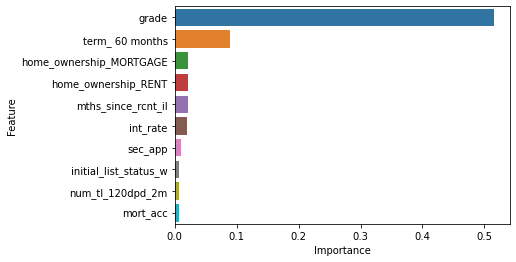

In [166]:
df = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf.feature_importances_})
df = df.sort_values('Importance', ascending=False)[:10]
sns.barplot(x='Importance', y='Feature', data=df)

# Xgboost i CatBoost były bardzo blisko, jednak dostrojony Xgboost osiągnął minimalnie lepsze F1 i accuracy
Na koniec nakreślę precision-recall curve dla najlepszego modelu.

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


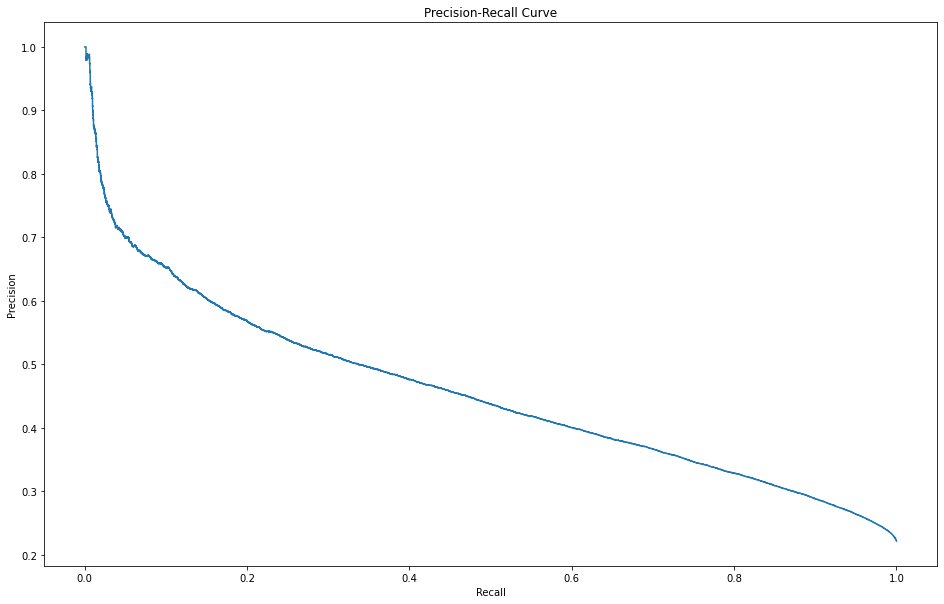

In [184]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 10)
y_pred_test = clf.predict_proba(X_test)[:, 1]
prec, rec, _ = precision_recall_curve(y_test, y_pred_test)
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.plot(rec, prec)

In [203]:
precs = []
recs = []
aucs = []
models = [dtree, catboost, clf, lreg, cv]
names = ['decision tree', 'Catboost', 'Xgboost', 'Log Reg', 'Linear SVM']
for i in range(len(models)):
    model = models[i]
    pred = model.predict(X_test)
    if i > 2:
        pred = model.predict(X_test_scaled)
    precs.append(precision_score(y_test, pred))
    recs.append(recall_score(y_test, pred))
    aucs.append(roc_auc_score(y_test, pred))

C:\Users\wojtek\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


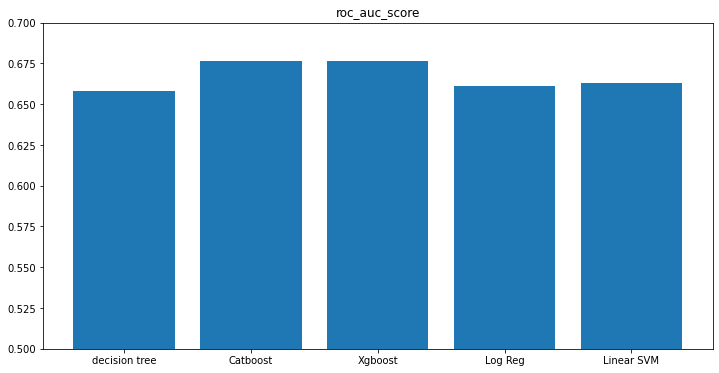

In [208]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt.bar(names, aucs)
plt.title('roc_auc_score')
plt.ylim(0.5, 0.7)
plt.savefig('auroc.png')

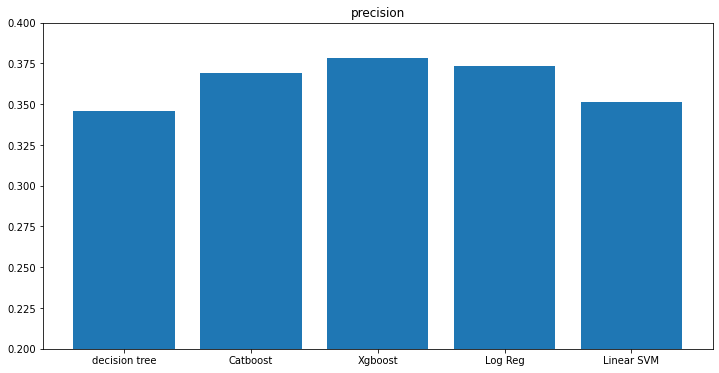

In [213]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt.bar(names, precs)
plt.title('precision')
plt.ylim(0.2, 0.4)
plt.savefig('precision.png')

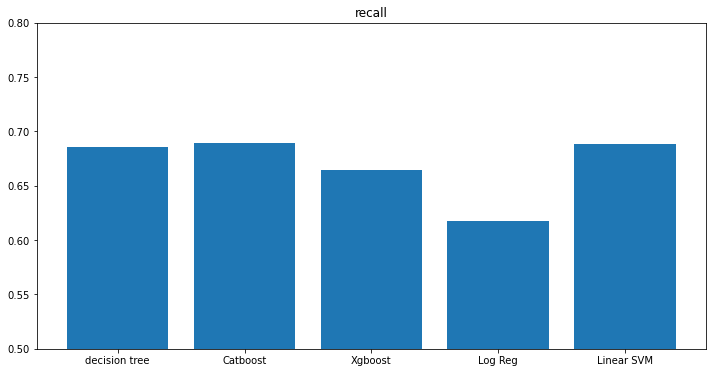

In [212]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt.bar(names, recs)
plt.title('recall')
plt.ylim(0.5, 0.8)
plt.savefig('recall.png')